<a href="https://colab.research.google.com/github/Samar2411/Python_Paper_Airplanes/blob/main/ModelingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Quiniela game - Machine Learning Model :
In this project, we will create a model that predicts the results of La Liga football game.  

In our model, We have used the previous data from La Liga matches, to train this model and then we will use these trained data in order to predicting the results of the 2020-2021 matches.
Since we are trying to predict results, we have an output is either 0 for tie, 1 for home_team and 2 for away_team in case they won, this means that we have a discrete output, which means it is better to use classification.

Knowing this, we chose Random Forest classification for building our model using the name of the home team, away team and their rankings to predict the results.

Trying multiple soultions, this has been the best solution that will get us a considerable amount of accuracy that can be recognised in a model

We tried to preform the prediction using previous data we exported from our analysis to a csv file in order to facilitate the work done here, and then we used again the sqlite dataset since each row, with some data modification will get us the desired result we need from this model.

**1- Importing needed Libraries:**
NumPy, Pandas and math are required for our data manipulation
Matplotlib for the data Visulaisation and plotting
sqlite3 to export our dataset and perform some queries
SciKit Lear is the Machine Learning Library used to import the classifcation model used in our assignment which is Random Forest

In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

**2- Connecting to the database and getting the data:**

In [ ]:
con = sqlite3.connect("laliga.sqlite")
df = pd.read_sql_query("SELECT * FROM Matches", con)
con.close()

**3- Data Manipulation and modification:**
Here in this section, we have firstly removed the NA values, to make sure that our dataset is clean, without any unwanted errors.

After this, we tried to calculate the score for each team whether it is the Home_team or away_team.

Then we calculated the points, ranking and we ordered the values based on the season, division, match day and the score.
After that, we modified the dataframe , where we removed the unnecessary columns and we kept the most important ones, Home_team, Away_team, Home_team_ranking, and the Away_team Ranking


In [ ]:
df.dropna(inplace = True)
df["home_score"] = df.apply(lambda x: int(x["score"].split(":")[0]), axis = 1)
df["away_score"] = df.apply(lambda x: int(x["score"].split(":")[1]), axis = 1)
df["winner_team"] = df.apply(lambda x : x["home_team"] if(x["home_score"] > x["away_score"]) else (x["away_team"] if(x["home_score"] < x["away_score"]) else "NaN"), axis = 1)
df["loser_team"] = df.apply(lambda x : x["home_team"] if(x["home_score"] < x["away_score"]) else (x["away_team"] if(x["home_score"] > x["away_score"]) else "NaN"), axis = 1)
df_home_team = df.copy()
df_home_team['team'] = df['home_team']
df_away_team = df.copy()
df_away_team['team'] = df['away_team']
df_total = pd.concat([df_home_team,df_away_team])
df_total = df_total.sort_values(by = ['season', 'division', 'matchday', 'score'])
df_total['W'] = df_total.apply(lambda x : 1 if x['winner_team'] == x['team'] else 0, axis = 1)
df_total['T'] = df_total.apply(lambda x : 1 if x['loser_team'] == 'NaN' else 0, axis = 1)
df_total['W'] = df_total.groupby(['season', 'division', 'team'])['W'].cumsum()
df_total['T'] = df_total.groupby(['season', 'division', 'team'])['T'].cumsum()
df_total['Pts'] = 3 * df_total['W'] + df_total['T']
df_total['rank'] = df_total.groupby(['division','season','matchday'])['Pts'].rank(method = 'min', ascending=False)
df_total = df_total.sort_index()
df_total_home_team = df_total.loc[df_total['home_team'] == df_total['team']]
df_total_away_team = df_total.loc[df_total['away_team'] == df_total['team']]
df['home_team_rank'] = df_total_home_team['rank']
df['away_team_rank'] = df_total_away_team['rank']
df.drop(columns = ['winner_team', 'loser_team'], inplace = True)
df.drop(columns = ['home_score', 'away_score'], inplace = True) 

**4- Clean Obtained dataset can be used for feature selection and target**
After we dropped the unncessary tables, added the ranking for eah team and kept the most important data, 
we have now obtained the dataset that we can use to train our model

In [ ]:
df

,season,division,matchday,date,time,home_team,away_team,score,home_team_rank,away_team_rank
16024,1995-1996,1,1,9/3/95,7:30 PM,CP Mérida,Real Betis,1:1,1.0,1.0
17318,1998-1999,1,1,8/29/98,9:00 PM,Alavés,Real Betis,0:0,5.0,5.0
17319,1998-1999,1,1,8/29/98,10:00 PM,Valencia,Atlético Madrid,1:0,1.0,17.0
17320,1998-1999,1,1,8/30/98,7:00 PM,Celta de Vigo,Dep. La Coruña,0:0,5.0,5.0
17321,1998-1999,1,1,8/30/98,7:00 PM,Real Sociedad,Real Oviedo,3:3,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...
48585,2021-2022,2,3,8/28/21,10:00 PM,Ponferradina,Girona,2:1,1.0,11.0
48586,2021-2022,2,3,8/29/21,5:00 PM,SD Amorebieta,UD Almería,2:1,14.0,4.0
48587,2021-2022,2,3,8/29/21,7:30 PM,CD Lugo,Real Valladolid,0:2,16.0,2.0
48588,2021-2022,2,3,8/29/21,7:30 PM,Real Sociedad B,CF Fuenlabrada,0:0,6.0,11.0


In [ ]:
#Drop the null values
df = df.dropna()
#Add a column with the winner of the match
df['winner'] = df['score'].str.split(':').str[0].astype(int) - df['score'].str.split(':').str[1].astype(int)
df['winner'] = np.where(df['winner'] > 0, 0, np.where(df['winner'] < 0, 2, 1))
df.sample(10)

,season,division,matchday,date,time,home_team,away_team,score,home_team_rank,away_team_rank,winner
23450,2014-2015,1,6,9/27/14,6:00 PM,Barcelona,Granada CF,6:0,1.0,7.0,0
47488,2019-2020,2,22,1/4/20,6:00 PM,CD Lugo,UD Almería,0:4,18.0,2.0,2
42668,2009-2010,2,4,9/19/09,6:00 PM,CD Numancia,Real Murcia,1:1,5.0,16.0,1
44138,2012-2013,2,11,10/28/12,6:00 PM,Alcorcón,Real Murcia,1:0,3.0,8.0,0
38947,2001-2002,2,1,8/26/01,9:30 PM,Real Murcia,SD Eibar,0:0,6.0,6.0,1
45720,2015-2016,2,29,3/13/16,5:00 PM,Córdoba CF,CD Lugo,1:2,3.0,9.0,2
24731,2017-2018,1,20,1/20/18,6:30 PM,Villarreal,Levante,2:1,5.0,17.0,0
47991,2020-2021,2,26,2/19/21,9:00 PM,Ponferradina,CD Mirandés,1:0,7.0,8.0,0
46419,2017-2018,2,9,10/10/17,9:00 PM,CyD Leonesa,Sporting Gijón,0:2,10.0,2.0,2
19446,2003-2004,1,23,2/8/04,9:00 PM,Real Zaragoza,Real Sociedad,2:1,17.0,10.0,0


In [ ]:
teams = [df['home_team'].unique()]

In [ ]:
#Assing to each team a number
teams = [df['home_team'].unique()]
#Convert the array to a list
teams = teams[0].tolist()

#Create a dictionary with the teams and their number
teams_dict = {}
for i in range(len(teams)):
    teams_dict[teams[i]] = i

#Create a new column with the number of the home team
df['home_team_num'] = df['home_team'].map(teams_dict)
#Create a new column with the number of the away team
df['away_team_num'] = df['away_team'].map(teams_dict)
df['winner'] = df['winner'].astype(int)
df['home_team_num'] = df['home_team_num'].astype(int)
df['away_team_num'] = df['away_team_num'].astype(int)

df.sample(10)

,season,division,matchday,date,time,home_team,away_team,score,home_team_rank,away_team_rank,winner,home_team_num,away_team_num
24915,2017-2018,1,38,5/20/18,4:15 PM,Athletic,Espanyol,0:1,16.0,11.0,2,13,5
44893,2013-2014,2,38,5/10/14,8:00 PM,Alcorcón,CD Lugo,1:0,11.0,11.0,0,68,74
43357,2010-2011,2,24,2/13/11,12:00 PM,CD Tenerife,Rayo Vallecano,2:1,18.0,1.0,0,17,25
23484,2014-2015,1,9,10/26/14,12:00 PM,Málaga CF,Rayo Vallecano,4:0,7.0,9.0,0,24,25
47144,2018-2019,2,33,4/5/19,9:00 PM,CD Tenerife,Sporting Gijón,0:1,17.0,8.0,2,17,35
46249,2016-2017,2,35,4/23/17,4:00 PM,RCD Mallorca,Córdoba CF,1:1,21.0,16.0,1,20,41
21907,2010-2011,1,3,9/20/10,9:00 PM,Dep. La Coruña,Getafe,2:2,13.0,8.0,1,15,31
24938,2018-2019,1,3,8/31/18,8:00 PM,Getafe,Real Valladolid,0:0,5.0,16.0,1,31,12
42663,2009-2010,2,3,9/13/09,5:00 PM,Real Murcia,SD Huesca,1:1,16.0,6.0,1,29,44
24734,2017-2018,1,20,1/21/18,4:15 PM,Real Madrid,Dep. La Coruña,7:1,4.0,18.0,0,10,15


In [ ]:
# We define the training data
train_data_fd = df[(df['season'] < '2019-2020') & (df['division'] == 1)] 

# We define the model
forest_model_fd = RandomForestRegressor(random_state=100, n_estimators=100)

# We select the predictors and the variable we want to predict
X_train_fd = train_data_fd[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]
Y_train_fd = train_data_fd['winner']

#We train the model
forest_model_fd.fit(X_train_fd, Y_train_fd)

RandomForestRegressor(random_state=100)

In [ ]:
#Use the model to predict the winner of matchdays of the season 2019-2020 for first division

#Select the test data
season_19_20_first_division = df[(df['season'] == '2019-2020') & (df['division'] == 1)]
test_19_20_first_division = season_19_20_first_division[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]

#Test the model
season_19_20_first_division['prediction_win'] = forest_model_fd.predict(test_19_20_first_division).astype(int)

#Calculate the accuracy of the model
accuracy_19_20_first_division = (season_19_20_first_division['winner'] == season_19_20_first_division['prediction_win']).sum() / len(season_19_20_first_division)

print(f'The accuracy of the model for predicting the first division results for the 2019-2020 season is: {round(accuracy_19_20_first_division,3)}%')

The accuracy of the model for predicting the first division results for the 2019-2020 season is: 0.487%


In [ ]:
# We define the training data
train_data_sd = df[(df['season'] < '2019-2020') & (df['division'] == 2)] 

# We define the model
forest_model_sd = RandomForestRegressor(random_state=100, n_estimators=100)

# We select the predictors and the variable we want to predict
X_train_sd = train_data_sd[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]
Y_train_sd = train_data_sd['winner']

#We train the model
forest_model_sd.fit(X_train_sd, Y_train_sd)

RandomForestRegressor(random_state=100)

In [ ]:
#Use the model to predict the winner of matchdays of the season 2019-2020 for first division

#Select the test data
season_19_20_second_division = df[(df['season'] == '2019-2020') & (df['division'] == 1)]
test_19_20_second_division = season_19_20_second_division[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]

#Test the model
season_19_20_second_division['prediction_win'] = forest_model_sd.predict(test_19_20_second_division).astype(int)

#Calculate the accuracy of the model
accuracy_19_20_second_division = (season_19_20_second_division['winner'] == season_19_20_second_division['prediction_win']).sum() / len(season_19_20_second_division)


print(f'The accuracy of the model for predicting the second division results for the 2019-2020 season is: {round(accuracy_19_20_second_division,3)}%')

The accuracy of the model for predicting the second division results for the 2019-2020 season is: 0.489%


In [ ]:
total_model_accuracy = (accuracy_19_20_first_division + accuracy_19_20_second_division)/2
print(f"Total model accuracy: {round(total_model_accuracy,3)}%")

Total model accuracy: 0.488%


In [ ]:
#Function to predict the winner of a matchday of 2019-2020 season
def predict_matchday(division, matchday):  
    season = '2019-2020' 
    if(division != 1 and division != 2):
            raise Exception('Prediction is only possible for first and second division')
    results = df[(df['season'] == season) & (df['division'] == division) & (df['matchday'] == matchday)]
    input_data = results[['home_team_num', 'away_team_num', 'home_team_rank', 'away_team_rank']]
    
    if(division == 1): 
        results['prediction_win'] = forest_model_fd.predict(input_data).astype(int)
    elif(division == 2): 
        results['prediction_win'] = forest_model_sd.predict(input_data).astype(int)

    results['prediction_win'] = results.apply(lambda x: 'X' if x['prediction_win'] == 1 else 1 if x['prediction_win'] == 0 else x['prediction_win'], axis = 1)
    for index, row in results.iterrows():
        print(f"{row['home_team']}  vs  {row['away_team']} ----> {row['prediction_win']} ")

In [ ]:
predict_matchday(1, 1)

Athletic  vs  Barcelona ----> 1 
Celta de Vigo  vs  Real Madrid ----> X 
Valencia  vs  Real Sociedad ----> 1 
RCD Mallorca  vs  SD Eibar ----> 1 
CD Leganés  vs  CA Osasuna ----> X 
Villarreal  vs  Granada CF ----> X 
Alavés  vs  Levante ----> 1 
Espanyol  vs  Sevilla FC ----> X 
Real Betis  vs  Real Valladolid ----> X 
Atlético Madrid  vs  Getafe ----> 1 


In [ ]:
#For the season 2019-2020, we will predict all the matchdays of the first division and second division and compare the results with the real results on the same dataset

season_19_20 = df[(df['season'] == '2019-2020')]
season_19_20['prediction_win'] = 0
season_19_20['prediction_win'] = season_19_20['prediction_win'].astype(int)
season_19_20['prediction_win'] = season_19_20.apply(lambda row: forest_model_fd.predict([[row['home_team_num'], row['away_team_num'], row['home_team_rank'], row['away_team_rank']]]) if row['division'] == 1 else forest_model_sd.predict([[row['home_team_num'], row['away_team_num'], row['home_team_rank'], row['away_team_rank']]]), axis=1)
season_19_20['prediction_win'] = season_19_20['prediction_win'].astype(int)

#Now we will to compact the information on a single data frame. We only want the columns season, division, matchday, home_team, away_team, winner and prediction_win
season_19_20 = season_19_20[['season', 'division', 'matchday', 'home_team', 'away_team', 'winner', 'prediction_win']]
season_19_20.head()

,season,division,matchday,home_team,away_team,winner,prediction_win
25298,2019-2020,1,1,Athletic,Barcelona,0,0
25299,2019-2020,1,1,Celta de Vigo,Real Madrid,2,1
25300,2019-2020,1,1,Valencia,Real Sociedad,1,0
25301,2019-2020,1,1,RCD Mallorca,SD Eibar,0,0
25302,2019-2020,1,1,CD Leganés,CA Osasuna,2,1


In [ ]:
#We will now calculate the accuracy of the model for each match
season_19_20['accuracy'] = season_19_20['winner'] == season_19_20['prediction_win']
season_19_20.head()

,season,division,matchday,home_team,away_team,winner,prediction_win,accuracy
25298,2019-2020,1,1,Athletic,Barcelona,0,0,True
25299,2019-2020,1,1,Celta de Vigo,Real Madrid,2,1,False
25300,2019-2020,1,1,Valencia,Real Sociedad,1,0,False
25301,2019-2020,1,1,RCD Mallorca,SD Eibar,0,0,True
25302,2019-2020,1,1,CD Leganés,CA Osasuna,2,1,False


In [ ]:
#Count the total number of home wins predicted by the model and the real number of home wins
home_wins_predcited = season_19_20['prediction_win'].value_counts()[0]
home_wins_real = season_19_20['winner'].value_counts()[0]
home_wins_correct = season_19_20[(season_19_20['winner'] == 0) & (season_19_20['prediction_win'] == 0)]['prediction_win'].count()

#Calculate the accuracy of the model for predicting home wins
home_wins_accuracy = (home_wins_predcited / home_wins_real) * 100
home_wins_accuracy_real = (home_wins_correct/ home_wins_real) * 100

#Count the total number of tie wins predicted by the model and the real number of tie wins
tie_predcited = season_19_20['prediction_win'].value_counts()[1]
tie_real = season_19_20['winner'].value_counts()[1]
tie_correct = season_19_20[(season_19_20['winner'] == 1) & (season_19_20['prediction_win'] == 1)]['prediction_win'].count()

#Calculate the accuracy of the model for predicting tie wins
tie_accuracy = (tie_predcited / tie_real) * 100
tie_accuracy_real = (tie_correct / tie_real) * 100

#Count the total number of away wins predicted by the model and the real number of away wins
away_wins_predcited = season_19_20['prediction_win'].value_counts()[2]
away_wins_real = season_19_20['winner'].value_counts()[2]
away_wins_correct = season_19_20[(season_19_20['winner'] == 2) & (season_19_20['prediction_win'] == 2)]['prediction_win'].count()

#Calculate the accuracy of the model for predicting away wins
away_wins_accuracy = (away_wins_predcited / away_wins_real) * 100
away_wins_accuracy_real = (away_wins_correct / away_wins_real) * 100

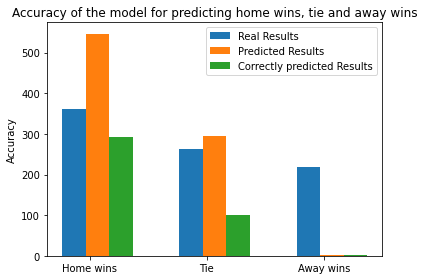

Accuracy of the model for predicting home wins: 80.663%
Accuracy of the model for predicting tie: 38.55%
Accuracy of the model for predicting away wins: 0.459%
Total model accuracy: 0.488%


In [ ]:
#Let's represent the real results, the predicted results and the correctlly predicted results in a bar plot

labels = ['Home wins', 'Tie', 'Away wins']
real_accuracy = [home_wins_real, tie_real, away_wins_real]
predicted_accuracy = [home_wins_predcited, tie_predcited, away_wins_predcited]
correctly_predicted_accuracy = [home_wins_correct, tie_correct, away_wins_correct]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/3, real_accuracy, width, label='Real Results')
rects2 = ax.bar(x + width/3, predicted_accuracy, width, label='Predicted Results')
rects3 = ax.bar(x + 4*width/3, correctly_predicted_accuracy, width, label='Correctly predicted Results')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of the model for predicting home wins, tie and away wins')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

#Print the accuracy of the model for predicting with only one decimal   
print(f"Accuracy of the model for predicting home wins: {round(home_wins_accuracy_real, 3)}%")
print(f"Accuracy of the model for predicting tie: {round(tie_accuracy_real, 3)}%")
print(f"Accuracy of the model for predicting away wins: {round(away_wins_accuracy_real, 3)}%")
print(f"Total model accuracy: {round(total_model_accuracy,3)}%")